## i. Introduction
Nama : Darmawan Wijaya </br>
Kelas : FTDS - 002 </br>
Obyektif : Mengaplikasikan konsep Convolution Neural Network untuk melakukan klasifikasi dari rambu lalu lintas (Road Sign)

## ii. Import Libraries
Libraries yang digunakan adalah:
1. Numpy
2. Pandas
3. Matplotlib
4. Tensor Flow
5. Keras

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers

import PIL
import PIL.Image
import pathlib
from PIL import Image


In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

print(tf.__version__)

Default GPU Device:/device:GPU:0
2.6.0


## iii. Data Loading
Data yang digunakan adalah data GTSRB - German Traffic Sign Recognition Benchmark yang berisikan:
1. Lebih dari 50.000 gambar
2. 40 Jenis Kelas Road Sign

Dataset terdapat pada https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign </br>
Namun untuk pada notebook ini, data tersebut sudah saya lakukan download pada google drive

In [3]:
#Melakukan mounting dari google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#Melakukan copy data dari google drive ke local data google colab
!cp -r /content/gdrive/MyDrive/Kaggle/gtsrb-german-traffic-sign.zip /content

In [5]:
#Melakukan unzip dari data yang sudah dicopy
!unzip /content/gtsrb-german-traffic-sign.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [6]:
train_folder=r'Train/'
test_folder=r'Test/'

In [7]:
import pathlib
train_dir = pathlib.Path(train_folder)
image_count = len(list(train_dir.glob('*/*.png')))
print(image_count)

39209


In [8]:
test_dir = pathlib.Path(test_folder)
test_count = len(list(test_dir.glob('*.png')))
print(test_count)

12630


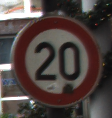

In [9]:
#Ambil contoh gambar
traffic = list(train_dir.glob('0/*'))
PIL.Image.open(str(traffic[200]))

In [10]:
dftrain = pd.read_csv('Train.csv')
dftest = pd.read_csv('Test.csv')

In [11]:
dftrain.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [12]:
dftest.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


## iv. Data Cleaning
Data cleaning adalah proses penyiapan data sebelum dilakukan eksplorasi dan pengolahan data lebih lanjut. </br>
Proses data cleaning yang digunakan pada proyek ini adalah: </br>
1. Pengecekan Data Duplikat
2. Pengecekan Missing Values

In [13]:
#Pengecekan data duplikat pada data train
duplicatetrain = dftrain[dftrain.duplicated()]
duplicatetrain

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path


In [14]:
#Pengecekan data duplikat pada data test
duplicatetest = dftest[dftest.duplicated()]
duplicatetest

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path


In [15]:
#Pengecekan Missing Values pada data train
dftrain.isnull().sum()

Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64

In [16]:
#Pengecekan Missing values pada data test
dftest.isnull().sum()

Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64

Tidak ada data duplikat maupun missing values pada data train dan test

## v. Data Exploration

### Eksplor jumlah data

In [17]:
print("No of images in train data : {0}".format(dftrain.shape[0]))
print("No of images in test data : {0}".format(dftest.shape[0]))

No of images in train data : 39209
No of images in test data : 12630


Terdapat 39.209 Gambar pada data train dan 12.630 gambar pada data test

### Explore Kelas

In [18]:
NUM_CATEGORIES = len(os.listdir(train_dir))
NUM_CATEGORIES

43

Terdapat 43 Jenis Rambu Lalu Lintas pada data yang digunakan

In [19]:
print(dftrain.ClassId.value_counts())


2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
8     1410
3     1410
11    1320
18    1200
35    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
30     450
34     420
6      420
16     420
22     390
36     390
40     360
20     360
21     330
39     300
24     270
29     270
32     240
42     240
41     240
27     240
37     210
19     210
0      210
Name: ClassId, dtype: int64


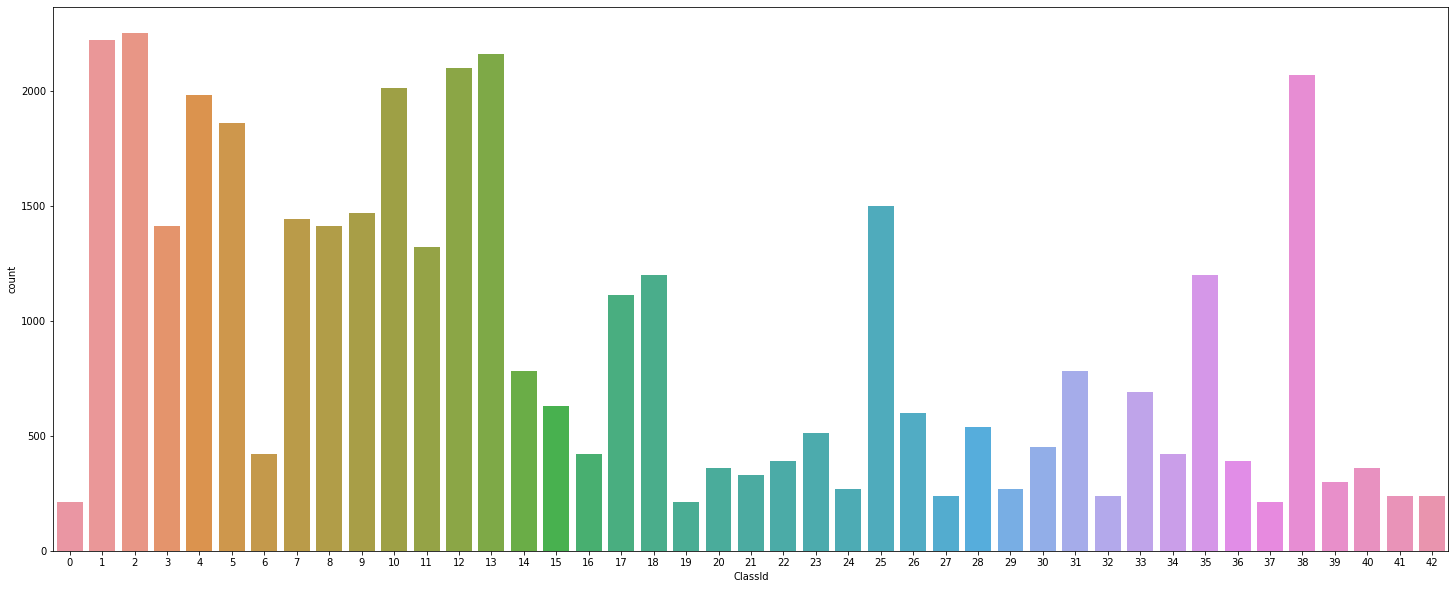

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((25,10))
sns.countplot(data = dftrain, x = 'ClassId', )
plt.show()

Jenis rambu lalu lintas tidak terdistribusi secara merata. </br>
Namun hal ini masih dapat diterima dikarenakan memang terdapat beberapa rambu lalu lintas yang memang lebih sering muncul dibandingkan dengan rambu lalu lintas lainnya. </br>

In [21]:
print(dftest.ClassId.value_counts())


2     750
1     720
13    720
12    690
38    690
10    660
4     660
5     630
25    480
9     480
3     450
8     450
7     450
11    420
35    390
18    390
17    360
14    270
31    270
15    210
33    210
26    180
28    150
23    150
16    150
30    150
6     150
22    120
34    120
36    120
24     90
39     90
42     90
20     90
21     90
29     90
40     90
32     60
27     60
41     60
19     60
37     60
0      60
Name: ClassId, dtype: int64


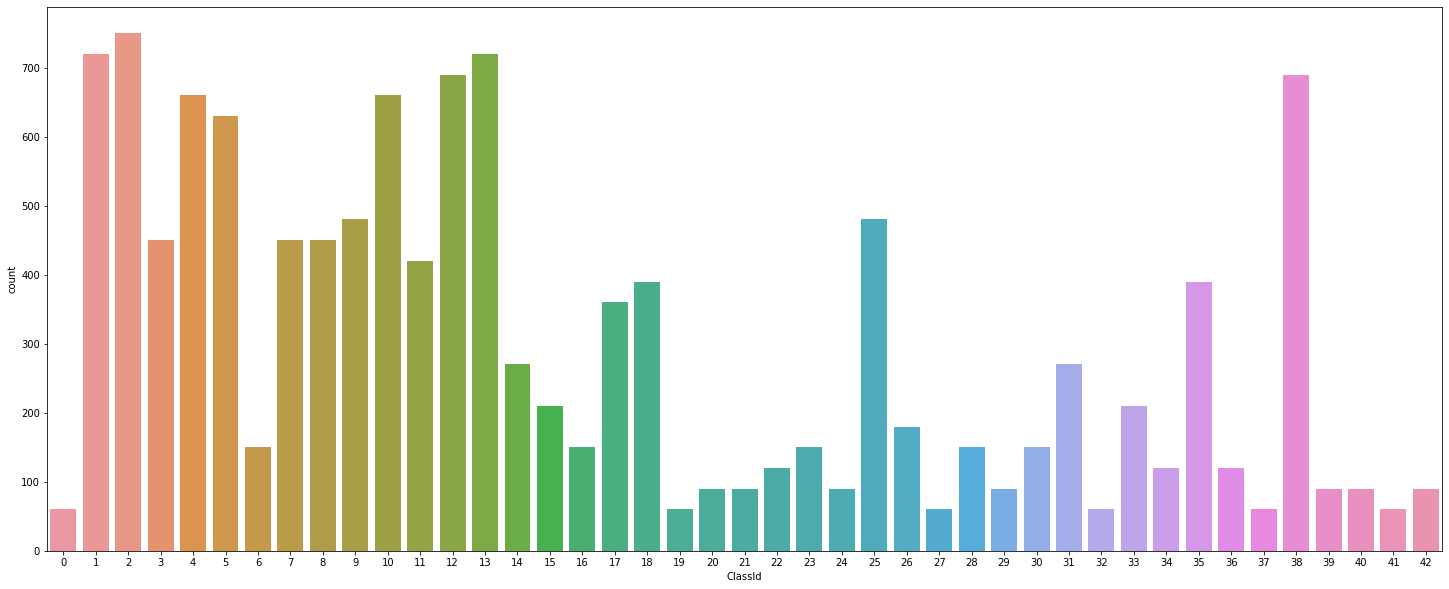

In [22]:
#Checking class distribution in test data
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((25,10))
sns.countplot(data = dftest, x = 'ClassId', )
plt.show()

Hasil eksplorasi pada data test memiliki kemiripan dengan data training. </br>
Disini juga menampilkan bahwa terdapat beberapa rambu lalu lintas yang lebih sering muncul dibandingkan dengan rambu lalu lintas lainnya

### Eksplor Height dan Width

In [23]:
dftrain['Height'].describe()

count    39209.000000
mean        50.328930
std         23.115423
min         25.000000
25%         35.000000
50%         43.000000
75%         58.000000
max        225.000000
Name: Height, dtype: float64

In [24]:
dftrain['Width'].describe()

count    39209.000000
mean        50.835880
std         24.306933
min         25.000000
25%         35.000000
50%         43.000000
75%         58.000000
max        243.000000
Name: Width, dtype: float64

Pada data training, didapatkan informasi bahwa:
1. Nilai height paling kecil adalah 25, sedangkan paling besar adalah 225
2. Nilai rata-rata height adalah 50, dan median nya adalah 43
3. Nilai widht paling kecil adalah 24.3, sedangkan paling besar adalah 243
4. Nilai rata-rata height adalah 50.8, dan mediannya adalah 43

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

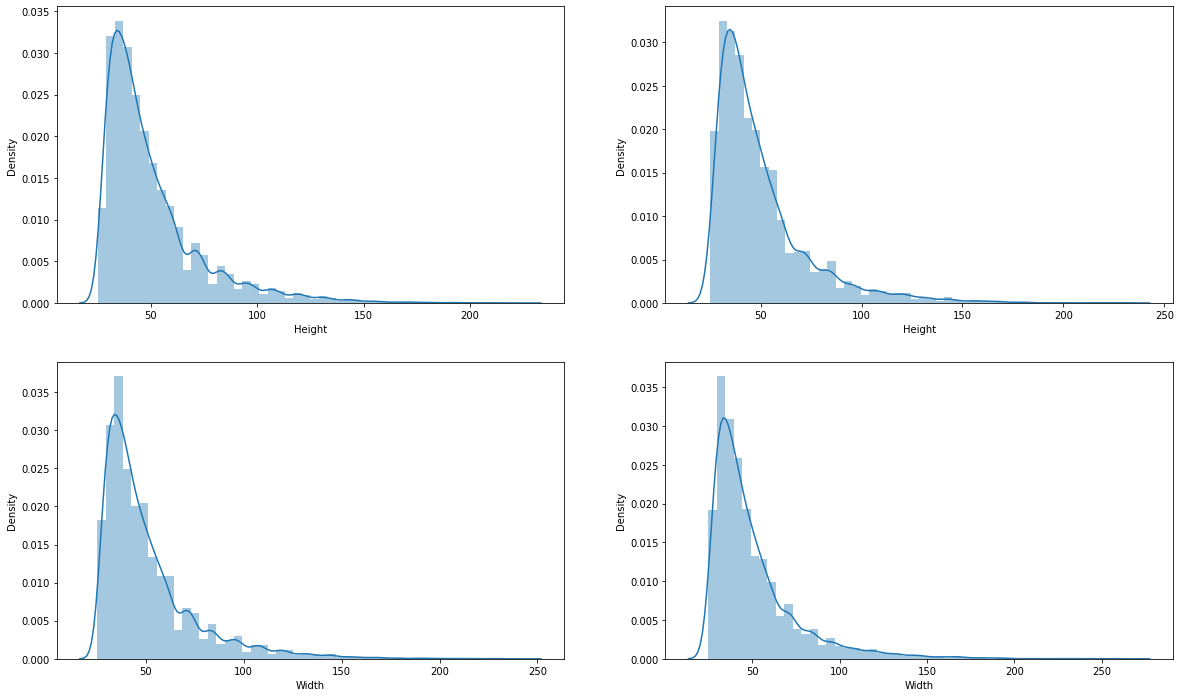

In [25]:
#Plotting data Width dan Height pada data Train dan Test
fig, ax = plt.subplots(2, 2)
fig.set_size_inches((20,12))
sns.distplot(dftrain['Height'], ax = ax[0][0])
fig.set_size_inches((20,12))
sns.distplot(dftest['Height'], ax = ax[0][1])
fig.set_size_inches((20,12))
sns.distplot(dftrain['Width'], ax = ax[1][0])
fig.set_size_inches((20,12))
sns.distplot(dftest['Width'], ax = ax[1][1])
plt.show()


Dari hasil plotting diatas, dapat disimpulkan bahwa data train dan data test memiliki distribusi height dan width yang sama



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

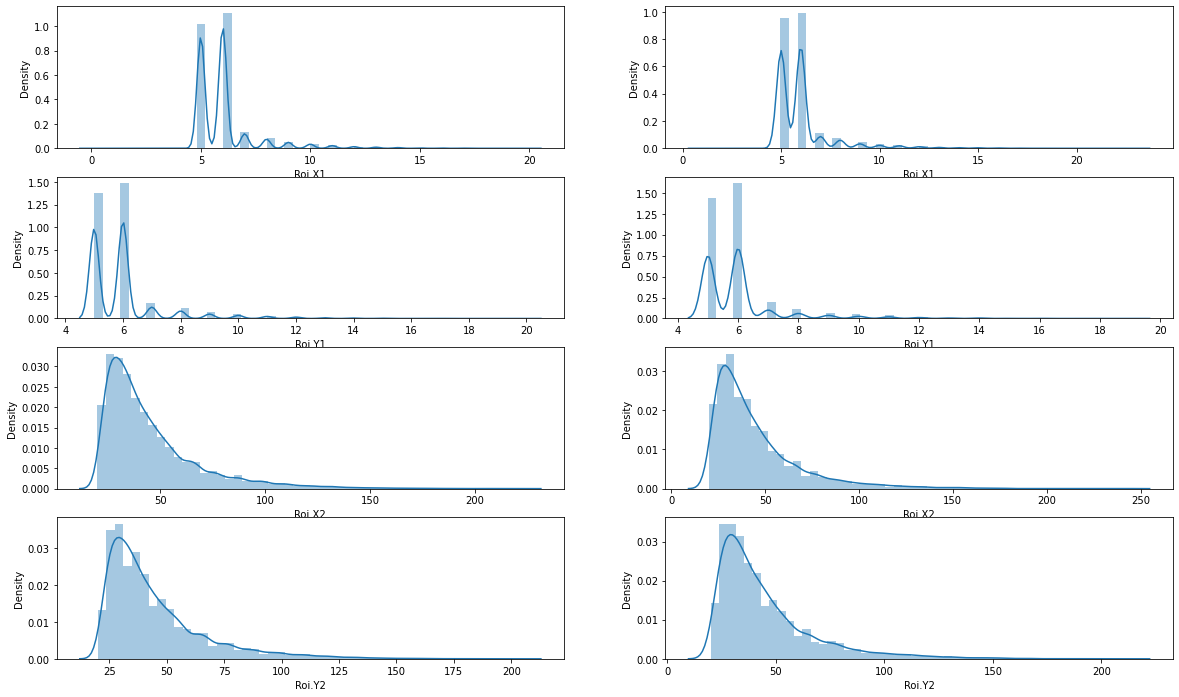

In [26]:
#Plotting data Width dan Height pada data Train dan Test
fig, ax = plt.subplots(4, 2)
fig.set_size_inches((20,12))
sns.distplot(dftrain['Roi.X1'], ax = ax[0][0])
fig.set_size_inches((20,12))
sns.distplot(dftest['Roi.X1'], ax = ax[0][1])
fig.set_size_inches((20,12))
sns.distplot(dftrain['Roi.Y1'], ax = ax[1][0])
fig.set_size_inches((20,12))
sns.distplot(dftest['Roi.Y1'], ax = ax[1][1])
fig.set_size_inches((20,12))
sns.distplot(dftrain['Roi.X2'], ax = ax[2][0])
fig.set_size_inches((20,12))
sns.distplot(dftest['Roi.X2'], ax = ax[2][1])
fig.set_size_inches((20,12))
sns.distplot(dftrain['Roi.Y2'], ax = ax[3][0])
fig.set_size_inches((20,12))
sns.distplot(dftest['Roi.Y2'], ax = ax[3][1])
plt.show()

Dari hasil plot data diatas, dapat diambil kesimpulan bahwa:
Distribusi dari fitur Roi.X1,X2,Y1,Y2 pada data train dan test tidak menunjukan perbedaan signifikan

### Kesimpulan Data Exploration

1. Terdapat 39.209 Gambar pada data train dan 12.630 gambar pada data test
2. Terdapat 43 Jenis Rambu Lalu Lintas pada data yang digunakan
3. Jenis rambu lalu lintas tidak terdistribusi secara merata. </br>
Namun hal ini masih dapat diterima dikarenakan memang terdapat beberapa rambu lalu lintas yang memang lebih sering muncul dibandingkan dengan rambu lalu lintas lainnya. </br>
4. Hasil eksplorasi pada data test memiliki kemiripan distribusi dengan data training
5. Pada data training, didapatkan informasi bahwa:
  1. Nilai height paling kecil adalah 25, sedangkan paling besar adalah 225
  2. Nilai rata-rata height adalah 50, dan median nya adalah 43
  3. Nilai widht paling kecil adalah 24.3, sedangkan paling besar adalah 243
  4. Nilai rata-rata height adalah 50.8, dan mediannya adalah 43
6. Data train dan data test memiliki distribusi height dan width yang sama
7. Distribusi dari fitur Roi.X1,X2,Y1,Y2 pada data train dan test tidak menunjukan perbedaan signifikan

## vi. Data Preprocessing

In [27]:
list_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)


In [28]:
for f in list_ds.take(5):
  print(f.numpy())

b'Train/11/00011_00041_00001.png'
b'Train/13/00013_00057_00000.png'
b'Train/11/00011_00006_00017.png'
b'Train/1/00001_00013_00012.png'
b'Train/23/00023_00001_00012.png'


In [29]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [30]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [31]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [32]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [33]:
class_names = np.array(sorted([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']


In [34]:
batch_size = 32
img_height = 30
img_width = 30


In [35]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [36]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

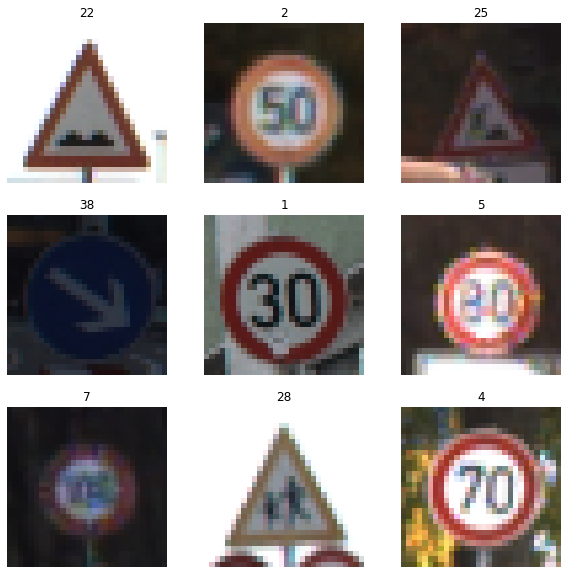

In [37]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [38]:
normalization_layer = layers.Rescaling(1./255)


In [39]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.05163398 1.0


## vii. Model Definition

In [40]:
#Definisi Model CNN yang akan digunakan
num_classes = 43

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [41]:
#Compiling model CNN
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## viii. Model Training

In [42]:
#Training Model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20)

Epoch 1/20
981/981 [==============================] - 52s 22ms/step - loss: 1.7891 - accuracy: 0.4887 - val_loss: 0.6358 - val_accuracy: 0.8102
Epoch 2/20
981/981 [==============================] - 6s 6ms/step - loss: 0.4147 - accuracy: 0.8784 - val_loss: 0.2302 - val_accuracy: 0.9341
Epoch 3/20
981/981 [==============================] - 6s 6ms/step - loss: 0.2038 - accuracy: 0.9405 - val_loss: 0.1420 - val_accuracy: 0.9612
Epoch 4/20
981/981 [==============================] - 6s 6ms/step - loss: 0.1262 - accuracy: 0.9650 - val_loss: 0.0836 - val_accuracy: 0.9770
Epoch 5/20
981/981 [==============================] - 6s 7ms/step - loss: 0.0896 - accuracy: 0.9742 - val_loss: 0.0721 - val_accuracy: 0.9778
Epoch 6/20
981/981 [==============================] - 6s 6ms/step - loss: 0.0701 - accuracy: 0.9795 - val_loss: 0.0545 - val_accuracy: 0.9832
Epoch 7/20
981/981 [==============================] - 6s 6ms/step - loss: 0.0569 - accuracy: 0.9826 - val_loss: 0.0431 - val_accuracy: 0.9884
Epoc

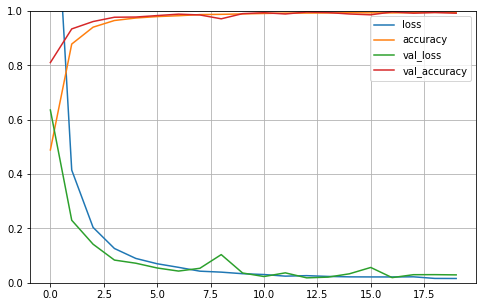

In [43]:
#Plotting hasil training
pd.DataFrame(history.history).plot(figsize =( 8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## ix. Model Improvement
Untuk mengurangi terjadinya overfitting, kami melakukan data augmentation dan melakukan dropout

In [44]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


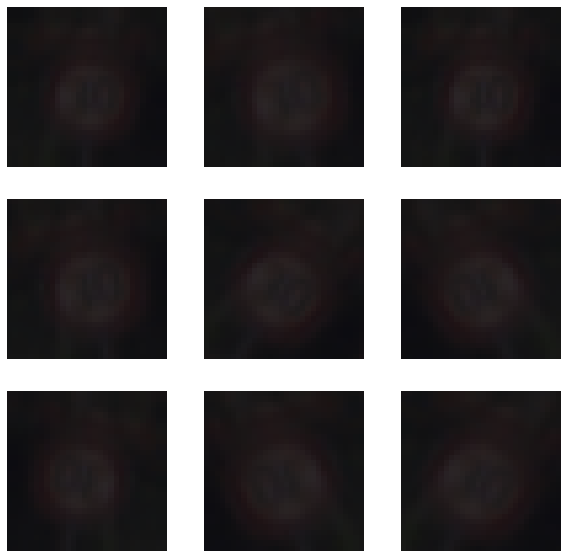

In [45]:
#Plotting contoh data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [46]:
model2 = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [47]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
model2.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 30, 30, 3)         0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 30, 30, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)         

In [49]:
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
981/981 [==============================] - 9s 8ms/step - loss: 2.2444 - accuracy: 0.3568 - val_loss: 1.2405 - val_accuracy: 0.5920
Epoch 2/20
981/981 [==============================] - 8s 8ms/step - loss: 1.1762 - accuracy: 0.6140 - val_loss: 0.8850 - val_accuracy: 0.7164
Epoch 3/20
981/981 [==============================] - 8s 8ms/step - loss: 0.8598 - accuracy: 0.7117 - val_loss: 0.6111 - val_accuracy: 0.8019
Epoch 4/20
981/981 [==============================] - 8s 8ms/step - loss: 0.6834 - accuracy: 0.7706 - val_loss: 0.4384 - val_accuracy: 0.8561
Epoch 5/20
981/981 [==============================] - 8s 8ms/step - loss: 0.5794 - accuracy: 0.8071 - val_loss: 0.3535 - val_accuracy: 0.8865
Epoch 6/20
981/981 [==============================] - 8s 8ms/step - loss: 0.4932 - accuracy: 0.8353 - val_loss: 0.3015 - val_accuracy: 0.9001
Epoch 7/20
981/981 [==============================] - 8s 8ms/step - loss: 0.4259 - accuracy: 0.8572 - val_loss: 0.2361 - val_accuracy: 0.9276
Epoch 

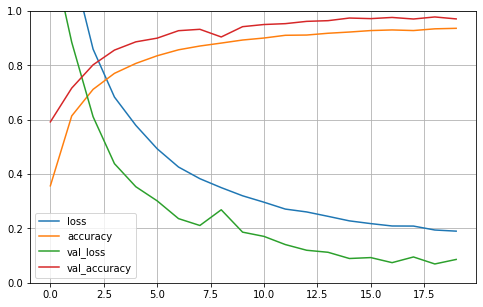

In [50]:
#Plotting hasil model improvement
pd.DataFrame(history.history).plot(figsize =( 8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## x. Model Evaluation

In [51]:
#Melakukan pengecekan apakah terdapat file lain/corrupt pada data test
import os
import imghdr
path = "./Test/"
dir_ = os.listdir(path)

for image in dir_:
    file = os.path.join(path,image)
    if not imghdr.what(file):
        print(file)
        os.remove(file) 

./Test/GT-final_test.csv


In [52]:
test = pd.read_csv('Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

In [53]:
data =[]
for img in imgs:
    path = tf.keras.utils.get_file(origin='file:///content/' + img)
    image = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model2.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predi = class_names[np.argmax(score)]
    data.append(predi)

Streaming output truncated to the last 5000 lines.
16384/1593 [====================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [54]:
y_pred = np.array(data)
y_pred = [int(i) for i in y_pred]
y_pred

[16,
 1,
 38,
 33,
 11,
 38,
 18,
 12,
 25,
 35,
 12,
 7,
 23,
 8,
 1,
 9,
 21,
 20,
 21,
 39,
 4,
 35,
 9,
 3,
 1,
 11,
 13,
 10,
 9,
 11,
 5,
 17,
 34,
 23,
 2,
 17,
 3,
 12,
 16,
 8,
 7,
 30,
 18,
 12,
 24,
 25,
 3,
 10,
 20,
 1,
 24,
 13,
 15,
 9,
 13,
 35,
 5,
 26,
 9,
 16,
 38,
 10,
 4,
 9,
 15,
 9,
 26,
 2,
 5,
 30,
 11,
 25,
 25,
 35,
 5,
 12,
 1,
 10,
 25,
 25,
 21,
 33,
 25,
 5,
 10,
 35,
 3,
 8,
 22,
 13,
 3,
 1,
 2,
 14,
 12,
 32,
 3,
 38,
 9,
 33,
 1,
 10,
 5,
 11,
 33,
 4,
 35,
 25,
 34,
 4,
 1,
 14,
 16,
 10,
 20,
 3,
 27,
 29,
 1,
 17,
 13,
 5,
 1,
 8,
 1,
 10,
 10,
 20,
 1,
 42,
 36,
 3,
 14,
 13,
 11,
 10,
 18,
 40,
 2,
 38,
 41,
 5,
 42,
 25,
 17,
 26,
 2,
 32,
 11,
 21,
 5,
 24,
 11,
 25,
 17,
 3,
 42,
 9,
 7,
 1,
 13,
 16,
 4,
 11,
 26,
 9,
 13,
 14,
 29,
 17,
 13,
 38,
 26,
 25,
 33,
 1,
 5,
 40,
 13,
 2,
 5,
 4,
 37,
 25,
 20,
 25,
 26,
 2,
 10,
 8,
 20,
 29,
 12,
 38,
 31,
 2,
 8,
 38,
 11,
 28,
 17,
 9,
 4,
 1,
 17,
 9,
 2,
 31,
 13,
 15,
 15,
 38,
 25,
 5,
 25

In [55]:
y_test = test["ClassId"].values

In [56]:
y_test

array([16,  1, 38, ...,  6,  7, 10])

In [57]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, y_pred)

In [58]:
cf

array([[ 40,  16,   0, ...,   0,   0,   0],
       [ 11, 640,  25, ...,   0,   0,   0],
       [  1,  49, 520, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  82,   0,   0],
       [  0,   0,   0, ...,   0,  45,   6],
       [  0,   0,   0, ...,   0,   0,  89]])

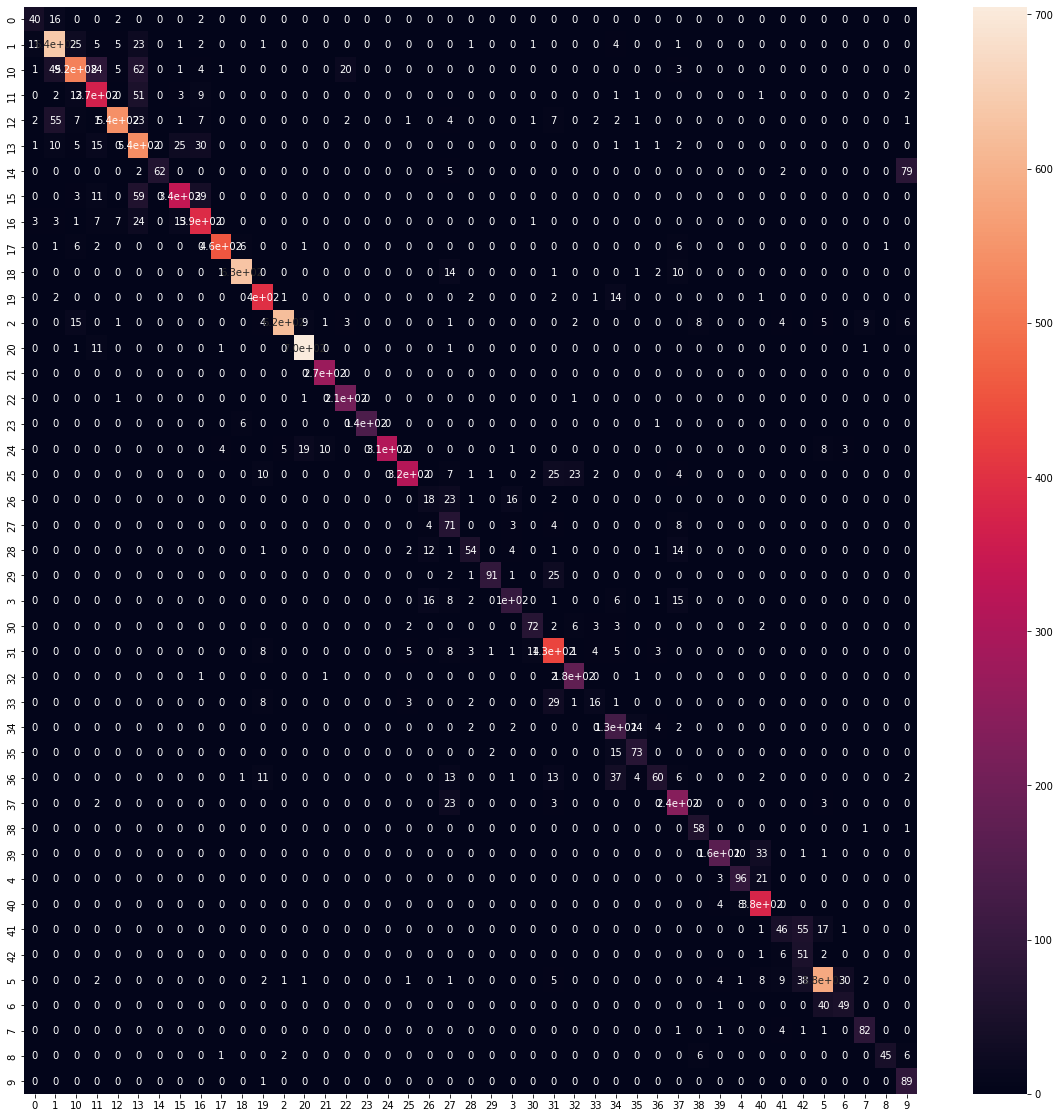

In [59]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = class_names,  columns = class_names)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68        60
           1       0.82      0.89      0.85       720
           2       0.87      0.69      0.77       750
           3       0.72      0.82      0.77       450
           4       0.96      0.82      0.89       660
           5       0.69      0.86      0.76       630
           6       1.00      0.41      0.58       150
           7       0.88      0.75      0.81       450
           8       0.81      0.86      0.83       450
           9       0.98      0.95      0.97       480
          10       0.98      0.96      0.97       660
          11       0.90      0.95      0.92       420
          12       0.99      0.90      0.94       690
          13       0.96      0.98      0.97       720
          14       0.96      1.00      0.98       270
          15       0.89      0.99      0.94       210
          16       1.00      0.95      0.98       150
          17       1.00    

Dari classification report diatas, dapat diambil kesimpulan bahwa:
1. Secara keseluruhan, model memiliki akurasi sebanyak 84%, rata-rata precision sebesar 86%, rata-rata recall sebesar 84% dan rata-rata F1 Score sebesar 84%
2. Untuk kelas 19,20,37,42 memiliki precision yang paling rendah yaitu dibawah 50%
3. Untuk kelas 6,19,27,30 dan 36 memiliki nilai recall yang paling rendah yang dibawah 50%
4. Untuk kelas 19,27, dan 36 memiliki nilai F1 Score yang paling rendah yang dibawah 50%
</br>

Dapat dikatakan bahwa performa model secara keseluruhan sudah bagus, namun untuk klasifikasi terhadap kelas 19,27 dan 36 masih mengalami kesulitan

## xi. Model Saving

In [61]:
#Melakukan saving model kedalam folder my model
!mkdir -p saved_model
localhost_save_option = tf.saved_model.SaveOptions(experimental_io_device="/job:localhost")
model2.save('saved_model/my_model', options=localhost_save_option)

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [62]:
#Melakukan Zip dari model yang sudah disave
!zip -r /content/my_model.zip /content/saved_model/my_model


  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 89%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 66%)
  adding: content/saved_model/my_model/keras_metadata.pb (deflated 92%)
  adding: content/saved_model/my_model/assets/ (stored 0%)


In [63]:
#Melakukan download dari model.zip ke dalam local data untuk digunakan lebih lanjut
from google.colab import files
files.download("/content/my_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## xii. Model Inference

In [64]:
testdf = pd.read_csv('Test.csv')
sampledf = testdf.sample(n=1000).reset_index()
sampledf.drop(columns='index',inplace=True)
sampledf

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,75,80,6,8,69,73,12,Test/12119.png
1,56,52,5,6,51,47,11,Test/08864.png
2,38,36,6,5,33,31,3,Test/04721.png
3,82,82,7,8,75,75,38,Test/04395.png
4,51,60,5,6,46,54,1,Test/01929.png
...,...,...,...,...,...,...,...,...
995,96,95,9,9,88,87,12,Test/10696.png
996,43,42,6,6,37,37,30,Test/01025.png
997,32,33,5,6,27,28,3,Test/00866.png
998,35,39,5,6,30,34,3,Test/10857.png


In [65]:

y_sample = sampledf["ClassId"].values
sample = sampledf["Path"].values

In [66]:
datasample =[]
for sam in sample:
    path = tf.keras.utils.get_file(origin='file:///content/' + sam)
    image = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)# Create a batch
    predictions = model2.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predi = class_names[np.argmax(score)]
    datasample.append(predi)

In [67]:
sample_pred = np.array(datasample)
sample_pred = [int(i) for i in sample_pred]
sample_pred

[12,
 11,
 3,
 38,
 1,
 5,
 9,
 25,
 20,
 40,
 4,
 8,
 9,
 7,
 12,
 9,
 17,
 4,
 12,
 2,
 7,
 17,
 28,
 11,
 5,
 3,
 3,
 5,
 15,
 31,
 10,
 19,
 5,
 13,
 13,
 9,
 40,
 39,
 34,
 4,
 7,
 23,
 8,
 17,
 42,
 1,
 28,
 13,
 25,
 23,
 17,
 10,
 21,
 37,
 12,
 1,
 20,
 2,
 16,
 36,
 8,
 13,
 25,
 21,
 11,
 11,
 18,
 30,
 35,
 3,
 34,
 38,
 9,
 14,
 37,
 5,
 4,
 2,
 10,
 9,
 4,
 12,
 17,
 22,
 28,
 10,
 11,
 17,
 2,
 8,
 17,
 4,
 1,
 12,
 33,
 13,
 28,
 8,
 15,
 10,
 23,
 37,
 14,
 2,
 10,
 15,
 2,
 17,
 8,
 25,
 4,
 8,
 4,
 10,
 2,
 7,
 12,
 1,
 36,
 30,
 1,
 1,
 10,
 16,
 32,
 38,
 31,
 1,
 34,
 38,
 28,
 23,
 5,
 15,
 2,
 21,
 1,
 8,
 26,
 10,
 24,
 40,
 38,
 35,
 25,
 21,
 42,
 2,
 14,
 1,
 13,
 1,
 37,
 10,
 35,
 13,
 27,
 30,
 25,
 3,
 21,
 40,
 5,
 1,
 33,
 8,
 5,
 23,
 2,
 42,
 38,
 18,
 25,
 29,
 3,
 8,
 7,
 18,
 41,
 35,
 18,
 30,
 25,
 25,
 35,
 1,
 14,
 12,
 22,
 35,
 38,
 15,
 25,
 38,
 23,
 5,
 12,
 38,
 10,
 18,
 3,
 9,
 13,
 20,
 13,
 38,
 22,
 26,
 11,
 25,
 18,
 5,
 5,
 20,
 

In [68]:
print(classification_report(y_sample, sample_pred))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.79      0.80      0.80        56
           2       0.86      0.69      0.77        71
           3       0.67      0.81      0.73        32
           4       0.98      0.88      0.93        51
           5       0.65      0.82      0.72        51
           6       1.00      0.50      0.67        10
           7       0.80      0.68      0.74        41
           8       0.74      0.84      0.78        37
           9       0.95      0.98      0.96        41
          10       0.98      0.95      0.97        44
          11       0.89      0.89      0.89        36
          12       1.00      0.93      0.96        42
          13       0.92      0.96      0.94        51
          14       0.96      1.00      0.98        23
          15       0.81      0.93      0.87        14
          16       1.00      0.94      0.97        16
          17       1.00    

## xiii. Kesimpulan
1. Tujuan dari permodelan ini adalah untuk melakukan klasifikasi dari gambar rambu-rambu lalu lintas
2. Dataset yang digunakan merupakan dataset dari The German Traffic Sign Benchmark
3. Tidak ditemukan data duplikat maupun missing values dari data yang ada.
4. Dari Data Exploration didapatkan bahwa:
  1. Terdapat 39.209 Gambar pada data train dan 12.630 gambar pada data test
  2. Terdapat 43 Jenis Rambu Lalu Lintas pada data yang digunakan
  3. Jenis rambu lalu lintas tidak terdistribusi secara merata. 
  4. Hasil eksplorasi pada data test memiliki kemiripan distribusi dengan data training.
5. Kami menggunakan input pipeline untuk melakukan preprocessing data seperti decoding image data dan resizing.
6. Kami menggunakan model CNN untuk melakukan training pada data
7. Kami melakukan model improvement untuk mencegah overfitting dengan cara melakukan data augmentation dan menambahkan dropout
8. Dari model evaluation terhadap data testing, dapat diambil kesimpulan bahwa:
  1. Secara keseluruhan, model memiliki akurasi sebanyak 85%, rata-rata precision sebesar 86%, rata-rata recall sebesar 85% dan rata-rata F1 Score sebesar 85%
  2. Dapat dikatakan bahwa performa model secara keseluruhan sudah bagus, namun untuk masih terdapat kesulitan untuk klasifikasi terhadap beberapa kelas yang memiliki nilai precision, recall dan F1 yang rendah pada kelas tersebut
9. Model inference dilakukan dengan cara mengambil random sampling sebanyak 1000 dari data Test.Csv